# Top-k upper bounds

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [36]:
import json

from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from analysis import selection, workloads
from postgres import explain
from transform import db, mosp, ues

In [30]:
job = workloads.job()

In [3]:
def read_workload(topk_length: int = np.nan, raw: str = "", *, linear: bool = True) -> pd.DataFrame:
    linear_suffix = "-linear" if linear else ""
    path = f"workloads/topk-setups/job-ues-results-topk-{topk_length}{linear_suffix}.csv" if not raw else raw
    df = pd.read_csv(path, converters={"query": mosp.MospQuery.parse, "ues_bounds": json.loads, "query_result": json.loads})
    df = selection.best_query_repetition(df, "label", performance_col="query_rt_total")
    df = selection.reorder(df)
    df.set_index("label", inplace=True)
    df["ues_final_bound"] = df["ues_final_bound"].astype("float")
    
    df.rename(columns={"query_rt_total": "rt", "ues_final_bound": "bound"}, inplace=True)
    if not raw:
        df["mode"] = "top-k"
        df["topk_length"] = topk_length
    else:
        df["mode"] = "ues"
        df["topk_length"] = 0
    df["linear"] = linear
    return df

In [4]:
print("Now reading UES workloads")
all_workloads = [read_workload(raw="workloads/job-ues-results-base-linear.csv", linear=True), read_workload(raw="workloads/job-ues-results-base.csv", linear=False)]
for topk_setting in [1, 5, 10, 20, 50, 100, 500]:
    print("Now reading workloads for topk =", topk_setting)
    all_workloads.append(read_workload(topk_setting, linear=True))
    all_workloads.append(read_workload(topk_setting, linear=False))
results = pd.concat(all_workloads)

Now reading UES workloads
Now reading workloads for topk = 1
Now reading workloads for topk = 5
Now reading workloads for topk = 10
Now reading workloads for topk = 20
Now reading workloads for topk = 50
Now reading workloads for topk = 100
Now reading workloads for topk = 500


## Workload analysis

In [5]:
results.groupby(["mode", "linear", "topk_length"]).rt.sum()

mode   linear  topk_length
top-k  False   1              384.841273
               5              392.619533
               10             393.579322
               20             395.623529
               50             394.737593
               100            385.806501
               500            382.638674
       True    1              404.534410
               5              418.798606
               10             417.877278
               20             418.343495
               50             417.462146
               100            421.909690
               500            419.633139
ues    False   0              376.990205
       True    0              393.746356
Name: rt, dtype: float64

In [6]:
results.groupby(["mode", "linear", "topk_length"]).bound.describe()

count          mean           std       min  \
mode  linear topk_length                                                
top-k False  1            113.0  1.959680e+17  1.972792e+18  150180.0   
             5            113.0  9.930727e+15  9.532100e+16    1160.0   
             10           113.0  1.797747e+15  1.682882e+16     900.0   
             20           113.0  4.214975e+14  3.773979e+15     790.0   
             50           113.0  5.606727e+13  5.834173e+14     764.0   
             100          113.0  8.512903e+12  8.935658e+13  150180.0   
             500          113.0  2.013742e+10  1.718704e+11   14049.0   
      True   1            113.0  1.959680e+17  1.972792e+18  150180.0   
             5            113.0  9.930727e+15  9.532100e+16    1160.0   
             10           113.0  1.797747e+15  1.682882e+16     900.0   
             20           113.0  4.214975e+14  3.773979e+15     790.0   
             50           113.0  5.606727e+13  5.834173e+14     764.0   
             100          113.0  8.512903e+12  8.935658e+13  150180.0   
             500          113.0  2.013742e+10  1.718704e+11   14049.0   
ues   False  0            113.0  1.959680e+17  1.972792e+18  150180.0   
      True   0            113.0  1.959680e+17  1.972792e+18  150180.0   

                                  25%           50%           75%  \
mode  linear topk_length                                            
top-k False  1            424168664.0  9.667429e+09  8.711122e+11   
             5             17106080.0  1.081999e+09  2.410247e+10   
             10            11305040.0  6.734479e+08  1.404086e+10   
             20             7303800.0  3.141781e+08  7.627424e+09   
             50             3613943.0  1.294136e+08  2.708854e+09   
             100           19157135.0  2.006026e+08  5.917777e+09   
             500            4630255.0  5.095397e+07  3.054260e+08   
      True   1            424168664.0  9.667429e+09  8.711122e+11   
             5             17106080.0  1.081999e+09  2.410247e+10   
             10            11305040.0  6.734479e+08  1.404086e+10   
             20             7303800.0  3.141781e+08  7.627424e+09   
             50             3613943.0  1.294136e+08  2.708854e+09   
             100           19157135.0  2.006026e+08  5.917777e+09   
             500            4630255.0  5.095397e+07  3.054260e+08   
ues   False  0            424168664.0  9.667429e+09  8.711122e+11   
      True   0            424168664.0  9.667429e+09  8.711122e+11   

                                   max  
mode  linear topk_length                
top-k False  1            2.096509e+19  
             5            1.011219e+18  
             10           1.782524e+17  
             20           3.980661e+16  
             50           6.202564e+15  
             100          9.499571e+14  
             500          1.809260e+12  
      True   1            2.096509e+19  
             5            1.011219e+18  
             10           1.782524e+17  
             20           3.980661e+16  
             50           6.202564e+15  
             100          9.499571e+14  
             500          1.809260e+12  
ues   False  0            2.096509e+19  
      True   0            2.096509e+19

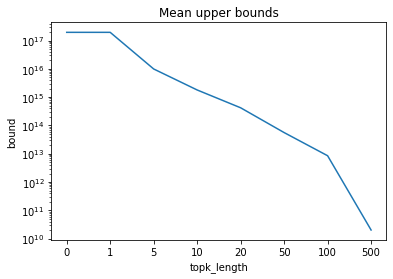

In [12]:
mean_topk_bounds = results[results["linear"]].groupby("topk_length").bound.mean().to_frame().reset_index()
mean_topk_bounds.topk_length = mean_topk_bounds.topk_length.astype(str)
g = sns.lineplot(data=mean_topk_bounds, x="topk_length", y="bound")
g.set(title="Mean upper bounds")
__ = g.set(yscale="log")

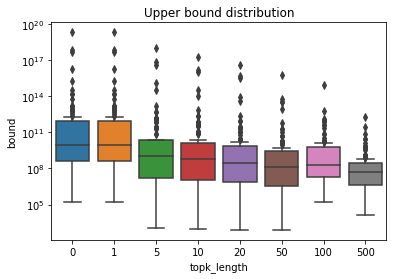

In [13]:
all_topk_bounds = results[results["linear"]].copy()
all_topk_bounds.topk_length = all_topk_bounds.topk_length.astype(str)
g = sns.boxplot(data=all_topk_bounds, x="topk_length", y="bound")
g.set(title="Upper bound distribution")
__ = g.set(yscale="log")

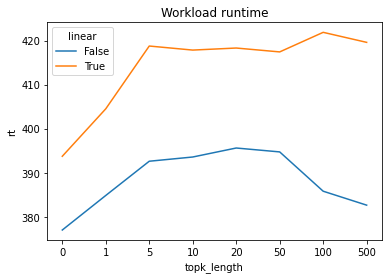

In [14]:
total_topk_runtime = results.groupby(["linear", "topk_length"]).rt.sum().to_frame().reset_index()
total_topk_runtime.topk_length = total_topk_runtime.topk_length.astype(str)
g = sns.lineplot(data=total_topk_runtime, x="topk_length", y="rt", hue="linear")
__ = g.set(title="Workload runtime")

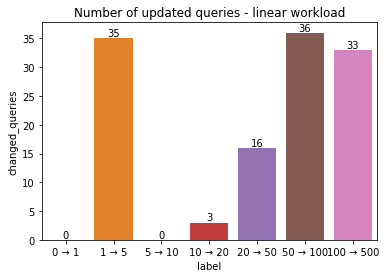

In [15]:
topk_settings = [0, 1, 5, 10, 20, 50, 100]
topk_setting_successors = [1, 5, 10, 20, 50, 100, 500]
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results[results["linear"] & (results["topk_length"] == topk)]
    topk_next_results = results[results["linear"] & (results["topk_length"] == topk_next)]
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries - linear workload")
__ = g.bar_label(g.containers[0])

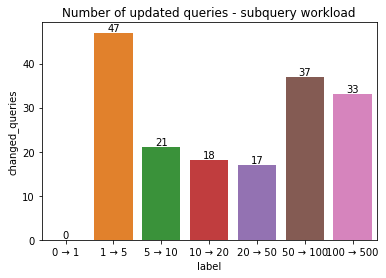

In [16]:
topk_settings = [0, 1, 5, 10, 20, 50, 100]
topk_setting_successors = [1, 5, 10, 20, 50, 100, 500]
changed_topk_queries = []
for topk, topk_next in zip(topk_settings, topk_setting_successors):
    topk_results = results[~results["linear"] & (results["topk_length"] == topk)]
    topk_next_results = results[~results["linear"] & (results["topk_length"] == topk_next)]
    join_path_comparison = pd.merge(topk_results.ues_join_path, topk_next_results.ues_join_path, left_index=True, right_index=True, suffixes=("", "_next"))
    join_path_comparison["stable"] = join_path_comparison.ues_join_path == join_path_comparison.ues_join_path_next
    stable_paths = join_path_comparison.stable.sum()
    changed_paths = len(join_path_comparison) - stable_paths
    label = f"{topk} → {topk_next}"
    changed_topk_queries.append({"topk": topk, "topk_next": topk_next, "changed_queries": changed_paths, "label": label})
changed_topk_queries = pd.DataFrame(changed_topk_queries)
g = sns.barplot(data=changed_topk_queries, x="label", y="changed_queries")
g.set(title="Number of updated queries - subquery workload")
__ = g.bar_label(g.containers[0])

## Runtime increase

In [ ]:
# TODO: determine maximum runtime increase after Top-k increase, check wheter outlier or distributed increase

## Upper bound increase

In [18]:
results_top50 = results[(results["topk_length"] == 50) & results["linear"]]
results_top100 = results[(results["topk_length"] == 100) & results["linear"]]
results_top50.rt.sum(), results_top100.rt.sum()

(417.46214599999996, 421.90968999999996)

In [21]:
results_top50.bound.min(), results_top100.bound.min()

(764.0, 150180.0)

In [32]:
results_top50[results_top50.bound == results_top50.bound.min()]

,query,optimization_success,ues_bounds,bound,optimization_time,ues_join_path,query_result,rt,run,mode,topk_length,linear
label,,,,,,,,,,,,
1a,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,True,"[{'join': ['info_type AS it', 'movie_info_idx ...",764.0,0.011638,mi_idx it t mc ct,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.697996,4,top-k,50,True
1b,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,True,"[{'join': ['info_type AS it', 'movie_info_idx ...",764.0,0.006184,mi_idx it t mc ct,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.558243,1,top-k,50,True
1c,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,True,"[{'join': ['info_type AS it', 'movie_info_idx ...",764.0,0.006643,mi_idx it t mc ct,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.571297,5,top-k,50,True
1d,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,True,"[{'join': ['info_type AS it', 'movie_info_idx ...",764.0,0.005252,mi_idx it t mc ct,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.614769,3,top-k,50,True


In [33]:
results_top100[results_top100.bound == results_top100.bound.min()]

,query,optimization_success,ues_bounds,bound,optimization_time,ues_join_path,query_result,rt,run,mode,topk_length,linear
label,,,,,,,,,,,,
1c,SELECT COUNT(*) FROM movie_info_idx AS mi_idx ...,True,"[{'join': ['info_type AS it', 'movie_info_idx ...",150180.0,0.007194,mi_idx it t mc ct,"[{'Plan': {'Node Type': 'Aggregate', 'Strategy...",0.578822,5,top-k,100,True


In [40]:
lowest_bound_label = "1c"
lowest_bound_query = job[lowest_bound_label]
lowest_bound_query

SELECT COUNT(*) FROM company_type AS ct, info_type AS it, movie_companies AS mc, movie_info_idx AS mi_idx, title AS t WHERE ct.kind = 'production companies' AND it.info = 'top 250 rank' AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%' AND mc.note LIKE '%(co-production)%' AND t.production_year > 2010 AND ct.id = mc.company_type_id AND t.id = mc.movie_id AND t.id = mi_idx.movie_id AND mc.movie_id = mi_idx.movie_id AND it.id = mi_idx.info_type_id

In [45]:
results_top50.loc[lowest_bound_label].query.join_path(short=True)

'mi_idx it t mc ct'

In [46]:
results_top100.loc[lowest_bound_label].query.join_path(short=True)

'mi_idx it t mc ct'

In [51]:
ues.optimize_query(lowest_bound_query,
                   table_cardinality_estimation="precise",
                   join_cardinality_estimation="topk", topk_list_length=50,
                   subquery_generation="disabled",
                   trace=True)

Input query: SELECT COUNT(*) FROM company_type AS ct, info_type AS it, movie_companies AS mc, movie_info_idx AS mi_idx, title AS t WHERE ct.kind = 'production companies' AND it.info = 'top 250 rank' AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%' AND mc.note LIKE '%(co-production)%' AND t.production_year > 2010 AND ct.id = mc.company_type_id AND t.id = mc.movie_id AND t.id = mi_idx.movie_id AND mc.movie_id = mi_idx.movie_id AND it.id = mi_idx.info_type_id
Running TopK cardinality estimation with k = 50
.. Bounds for candidate movie_companies AS mc :: Filter: 37545 | PKs: [37545, 37545]
.. Bounds for candidate movie_info_idx AS mi_idx :: Filter: 2367725 | PKs: [789155, 2367725]
Selected first table: movie_companies AS mc with PK/FK joins [company_type AS ct, title AS t]
.. Adding PK join with company_type AS ct on ct.id = mc.company_type_id
.. Adding PK join with title AS t on t.id = mc.movie_id
.. Base estimates: {company_type AS ct: 1, info_type AS it: 1, movie_companies AS

SELECT COUNT(*) FROM movie_companies AS mc JOIN company_type AS ct ON ct.id = mc.company_type_id AND ct.kind = 'production companies' AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%' AND mc.note LIKE '%(co-production)%' JOIN title AS t ON t.id = mc.movie_id AND t.production_year > 2010 JOIN movie_info_idx AS mi_idx ON t.id = mi_idx.movie_id AND mc.movie_id = mi_idx.movie_id JOIN info_type AS it ON it.id = mi_idx.info_type_id AND it.info = 'top 250 rank'

In [49]:
ues.optimize_query(lowest_bound_query,
                   table_cardinality_estimation="precise",
                   join_cardinality_estimation="topk", topk_list_length=100,
                   subquery_generation="disabled",
                   trace=True)

Input query: SELECT COUNT(*) FROM company_type AS ct, info_type AS it, movie_companies AS mc, movie_info_idx AS mi_idx, title AS t WHERE ct.kind = 'production companies' AND it.info = 'top 250 rank' AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%' AND mc.note LIKE '%(co-production)%' AND t.production_year > 2010 AND ct.id = mc.company_type_id AND t.id = mc.movie_id AND t.id = mi_idx.movie_id AND mc.movie_id = mi_idx.movie_id AND it.id = mi_idx.info_type_id
Running TopK cardinality estimation with k = 100
.. Bounds for candidate movie_companies AS mc :: Filter: 37545 | PKs: [37545, 37545]
.. Bounds for candidate movie_info_idx AS mi_idx :: Filter: 2367725 | PKs: [15793, 2367725]
Selected first table: movie_info_idx AS mi_idx with PK/FK joins [info_type AS it, title AS t]
.. Adding PK join with info_type AS it on it.id = mi_idx.info_type_id
.. Adding PK join with title AS t on t.id = mi_idx.movie_id
.. Base estimates: {company_type AS ct: 1, info_type AS it: 1, movie_companies 

SELECT COUNT(*) FROM movie_info_idx AS mi_idx JOIN info_type AS it ON it.id = mi_idx.info_type_id AND it.info = 'top 250 rank' JOIN title AS t ON t.id = mi_idx.movie_id AND t.production_year > 2010 JOIN movie_companies AS mc ON t.id = mc.movie_id AND mc.movie_id = mi_idx.movie_id AND mc.note NOT LIKE '%(as Metro-Goldwyn-Mayer Pictures)%' AND mc.note LIKE '%(co-production)%' JOIN company_type AS ct ON ct.id = mc.company_type_id AND ct.kind = 'production companies'